Shape: (3480, 11)

Data Types:
 Unnamed: 0            int64
Property Name        object
Price                 int64
House Type           object
Area in sq ft         int64
No. of Bedrooms       int64
No. of Bathrooms      int64
No. of Receptions     int64
Location             object
City/County          object
Postal Code          object
dtype: object

Summary Statistics:
          Unnamed: 0      Property Name         Price        House Type  \
count   3480.000000               3480  3.480000e+03              3480   
unique          NaN               2380           NaN                 8   
top             NaN  Television Centre           NaN  Flat / Apartment   
freq            NaN                 17           NaN              1565   
mean    1739.500000                NaN  1.864173e+06               NaN   
std     1004.733796                NaN  2.267283e+06               NaN   
min        0.000000                NaN  1.800000e+05               NaN   
25%      869.750000             

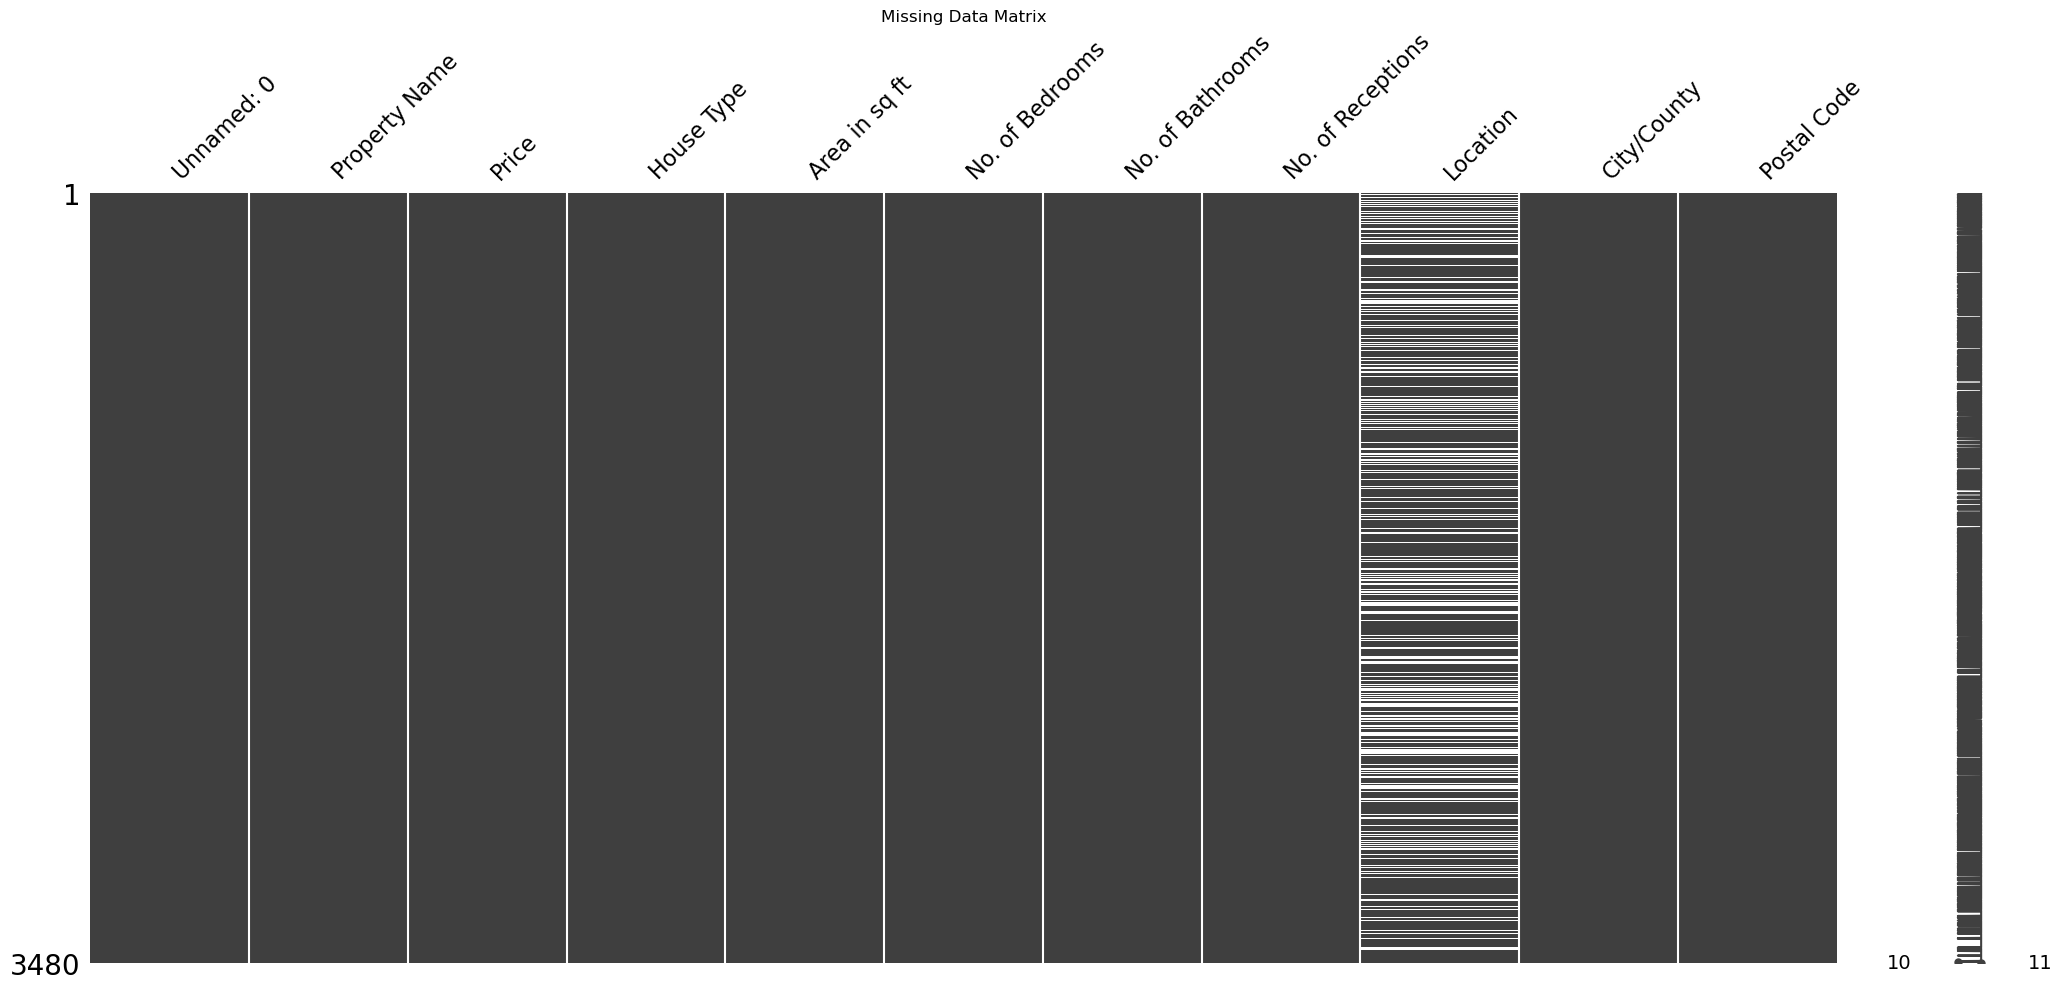

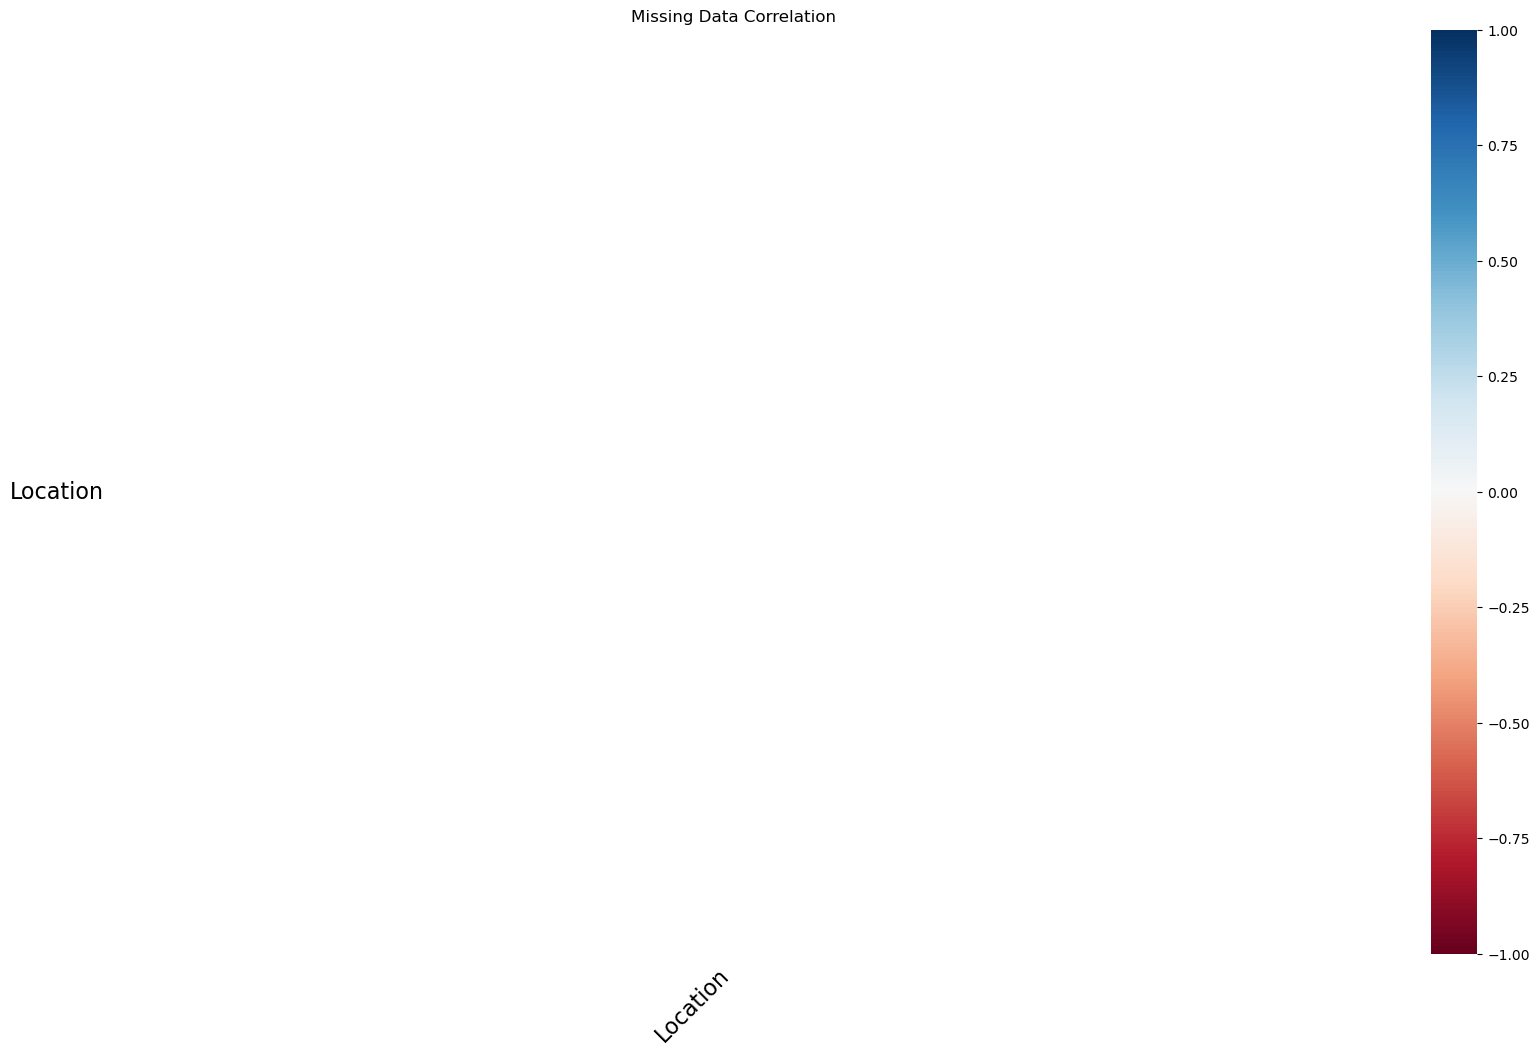

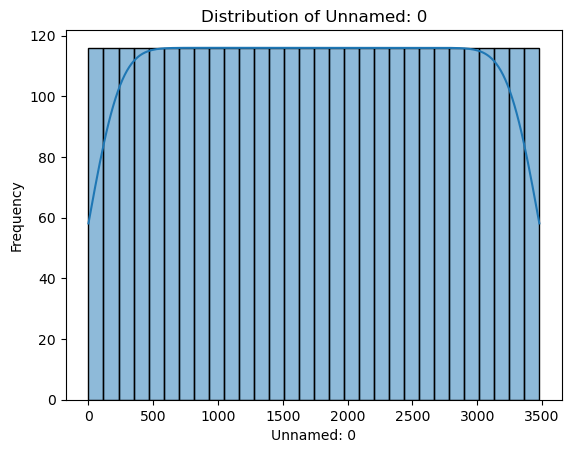

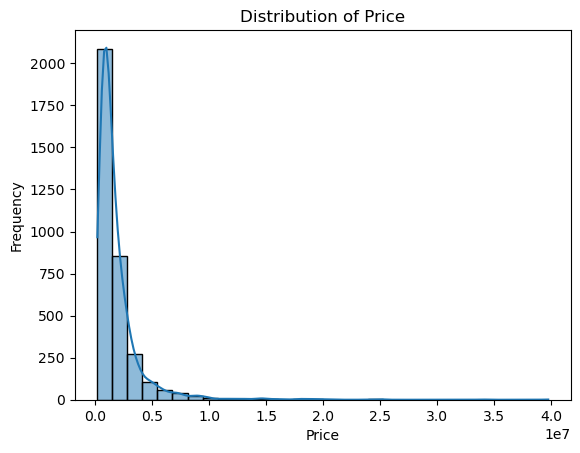

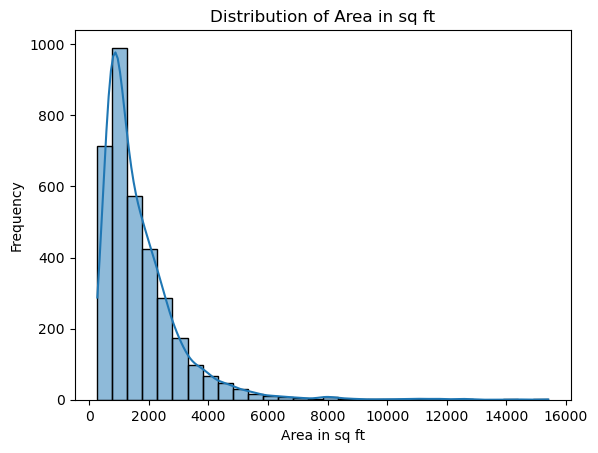

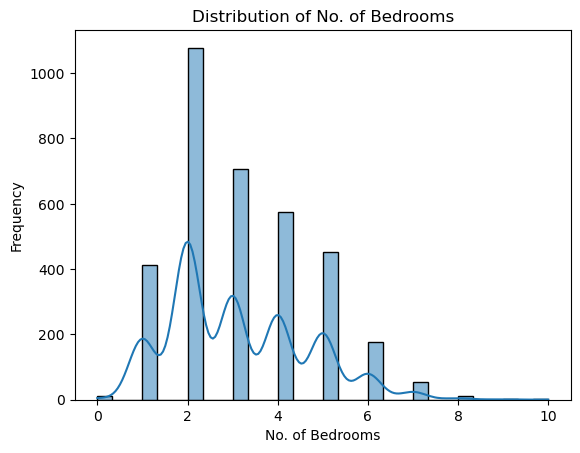

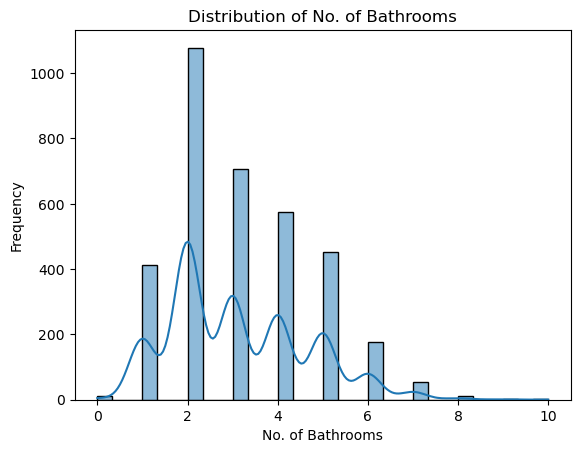

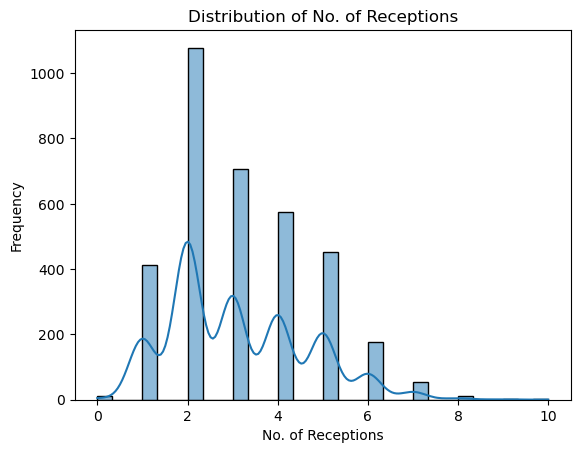

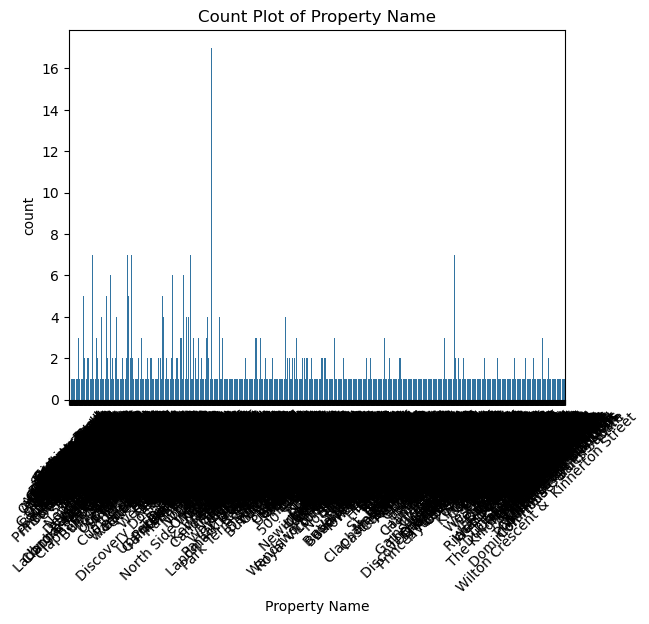

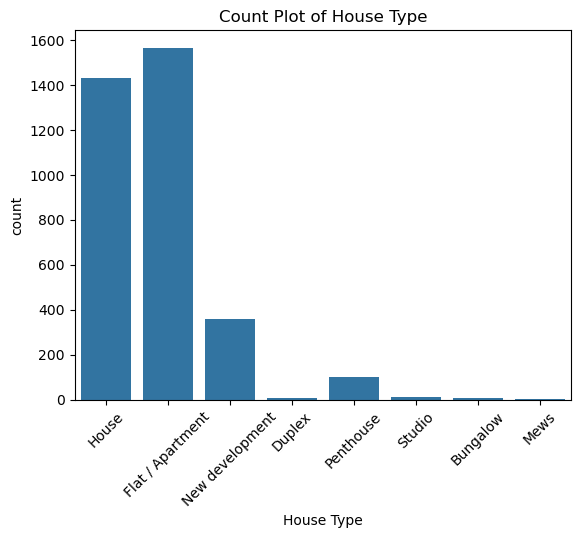

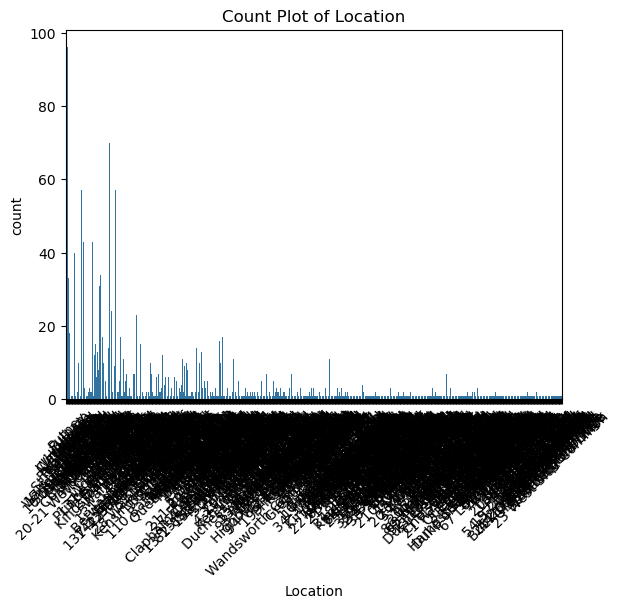

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




# Load the dataset
file_path = 'London.csv'
df = pd.read_csv(file_path)

# 1. Basic Info
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nSummary Statistics:\n", df.describe(include='all'))
print("\nMissing Values:\n", df.isnull().sum())

# 2. Visualizing Missing Data
msno.matrix(df)
plt.title("Missing Data Matrix")
plt.show()

msno.heatmap(df)
plt.title("Missing Data Correlation")
plt.show()

# 3. Distribution of Numerical Features
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in numerical_cols:
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# 4. Count Plots for Categorical Features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_cols:
    sns.countplot(data=df, x=col)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.show()

# 5. Correlation Heatmap (for numerical features)
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

# 6. Boxplots for Numerical vs Categorical (if a target exists)
target = None  # Change this to your target column if known

if target and target in df.columns:
    for col in numerical_cols:
        if col != target:
            sns.boxplot(data=df, x=target, y=col)
            plt.title(f'{col} vs {target}')
            plt.xticks(rotation=45)
            plt.show()

# 7. Pairplot (Optional - heavy on resources)
if len(numerical_cols) <= 5:  # Limit for performance
    sns.pairplot(df[numerical_cols].dropna())
    plt.show()


In [ ]:

# --- LOAD DATA ---
df = pd.read_csv('London.csv')

# --- DATA CLEANING ---
df = df.drop_duplicates()

numerical_cols = ['Price', 'Area in sq ft', 'No. of Bedrooms', 'No. of Bathrooms', 'No. of Receptions']
categorical_cols = ['Property Name', 'House Type', 'Location', 'City/County', 'Postal Code']

# Imputers
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# --- FEATURE ENGINEERING ---
df['price_per_sqft'] = df['Price'] / df['Area in sq ft']
numerical_cols.append('price_per_sqft')

# Remove outliers
for col in numerical_cols:
    mean = df[col].mean()
    std = df[col].std()
    df = df[(df[col] >= mean - 3 * std) & (df[col] <= mean + 3 * std)]

# Drop rows with missing target
df = df.dropna(subset=['Price'])

# Features and target
target = 'Price'
X = df.drop(columns=[target])
y = df[target]

# Updated columns
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputer', num_imputer), ('scaler', StandardScaler())]), numerical_cols),
    ('cat', Pipeline([('imputer', cat_imputer), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), categorical_cols)
])

# --- DATA SPLITTING ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# --- MODELING ---
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# --- EVALUATION FUNCTION ---
def evaluate_model(name, model, X_val, y_val):
    y_pred = model.predict(X_val)
    print(f'\n{name} Evaluation:')
    print(f'MAE : {mean_absolute_error(y_val, y_pred):.2f}')
    print(f'MSE : {mean_squared_error(y_val, y_pred):.2f}')
    print(f'RMSE: {mean_squared_error(y_val, y_pred, squared=False):.2f}')
    print(f'R²  : {r2_score(y_val, y_pred):.4f}')

# --- TRAIN AND EVALUATE ---
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    evaluate_model(name, model, X_val_processed, y_val)

# --- HYPERPARAMETER TUNING (Random Forest) ---
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train_processed, y_train)
best_rf = rf_search.best_estimator_
evaluate_model('RandomForest (Tuned)', best_rf, X_val_processed, y_val)



LinearRegression Evaluation:
MAE : 2941952641690013.00
MSE : 47297373179132049608987700625408.00
RMSE: 6877308570882366.00
R²  : -38874492959981469696.0000


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Ridge Evaluation:
MAE : 219109.72
MSE : 119609761965.95
RMSE: 345846.44
R²  : 0.9017


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.652e+12, tolerance: 3.077e+11
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Lasso Evaluation:
MAE : 226340.54
MSE : 136783941304.70
RMSE: 369843.13
R²  : 0.8876

DecisionTree Evaluation:
MAE : 63220.80
MSE : 14928445955.87
RMSE: 122182.02
R²  : 0.9877


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



RandomForest Evaluation:
MAE : 30422.49
MSE : 5016204066.57
RMSE: 70825.17
R²  : 0.9959


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



XGBoost Evaluation:
MAE : 34128.49
MSE : 3957433965.54
RMSE: 62908.14
R²  : 0.9967


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



RandomForest (Tuned) Evaluation:
MAE : 32317.07
MSE : 5378018639.88
RMSE: 73334.98
R²  : 0.9956


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Shape: (3480, 11)

Data Types:
 Unnamed: 0            int64
Property Name        object
Price                 int64
House Type           object
Area in sq ft         int64
No. of Bedrooms       int64
No. of Bathrooms      int64
No. of Receptions     int64
Location             object
City/County          object
Postal Code          object
dtype: object

Summary Statistics:
          Unnamed: 0      Property Name         Price        House Type  \
count   3480.000000               3480  3.480000e+03              3480   
unique          NaN               2380           NaN                 8   
top             NaN  Television Centre           NaN  Flat / Apartment   
freq            NaN                 17           NaN              1565   
mean    1739.500000                NaN  1.864173e+06               NaN   
std     1004.733796                NaN  2.267283e+06               NaN   
min        0.000000                NaN  1.800000e+05               NaN   
25%      869.750000             

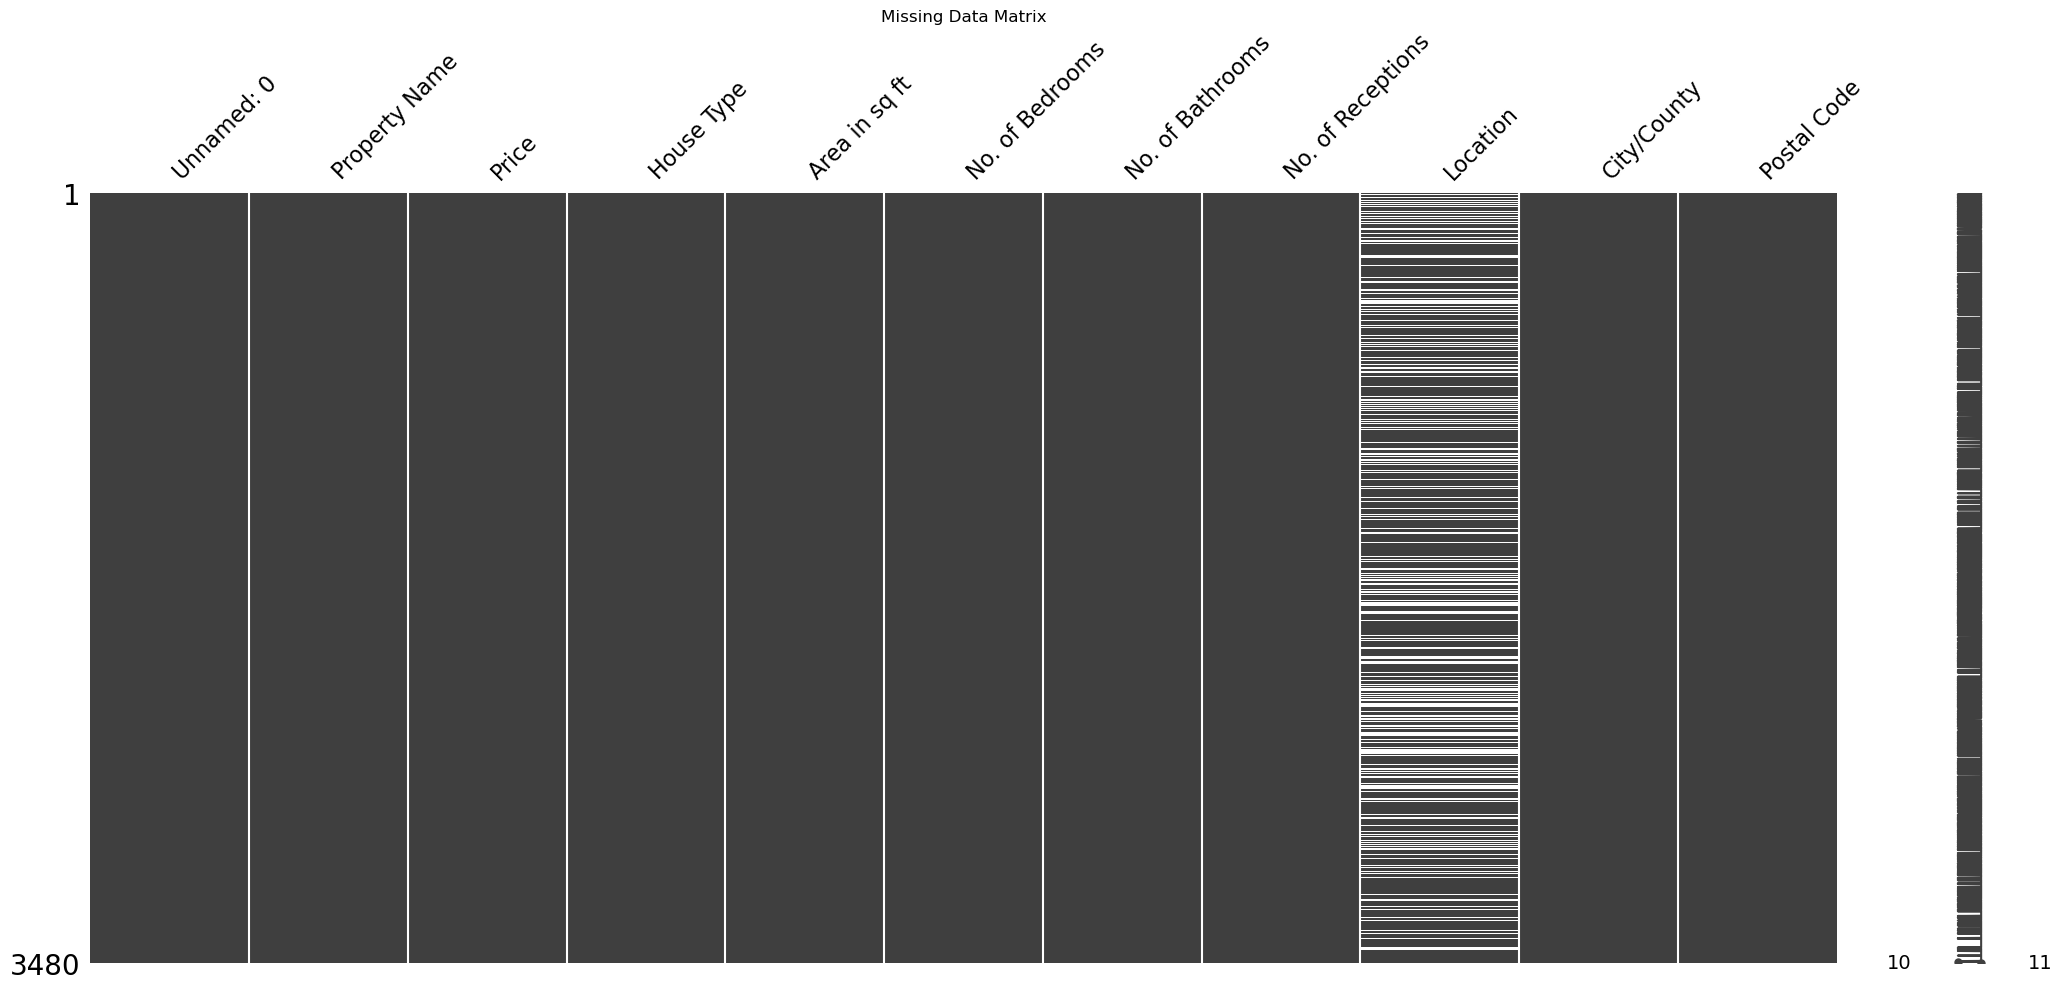

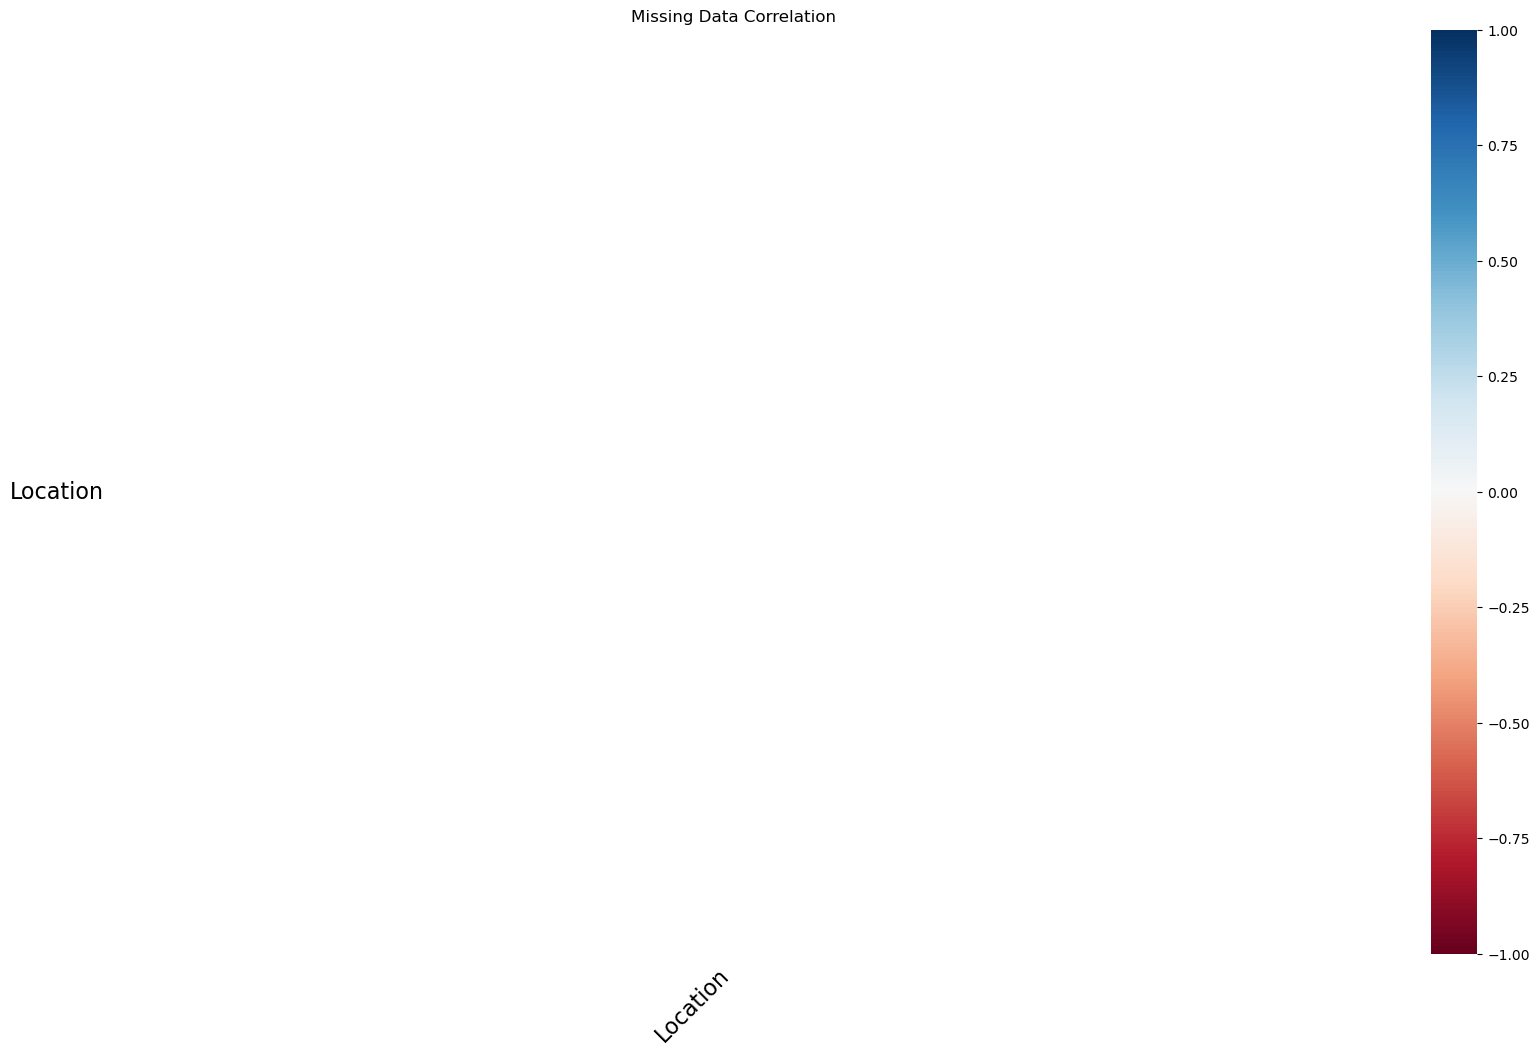

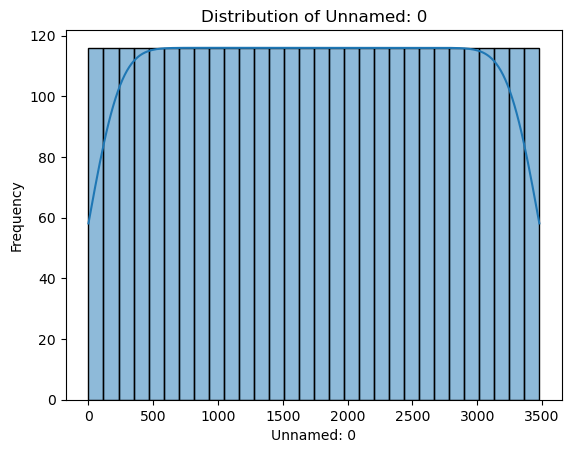

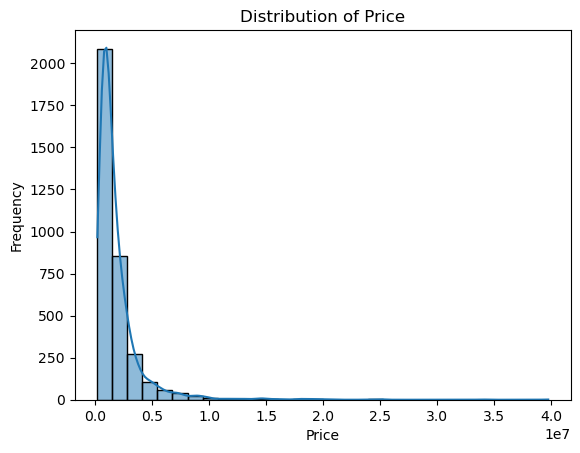

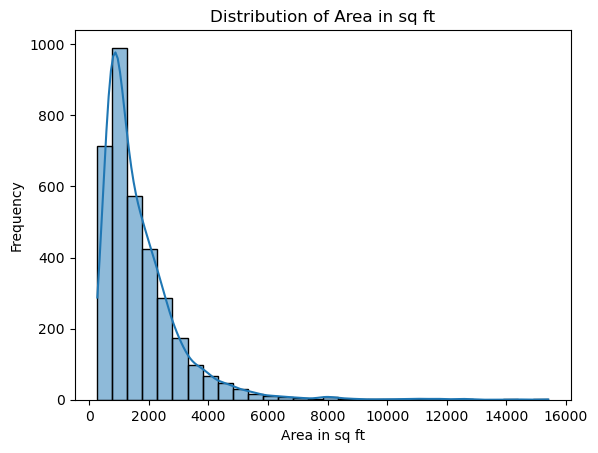

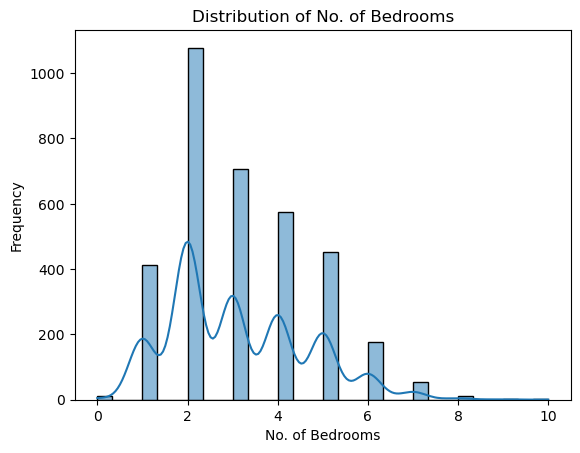

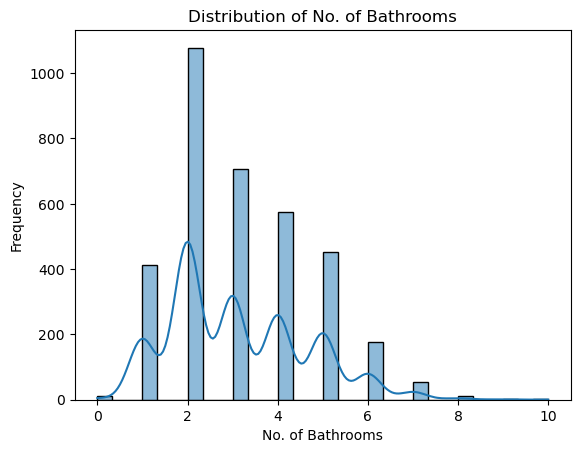

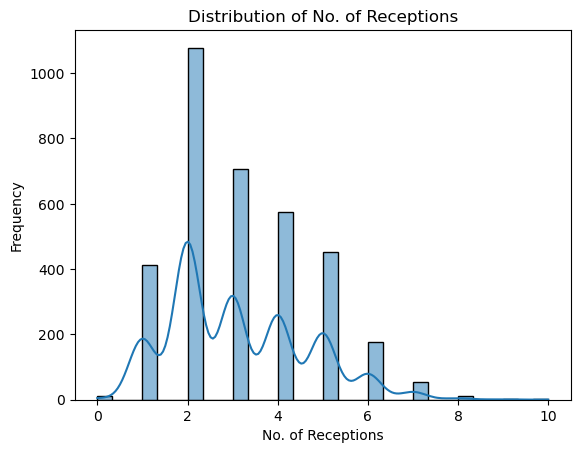

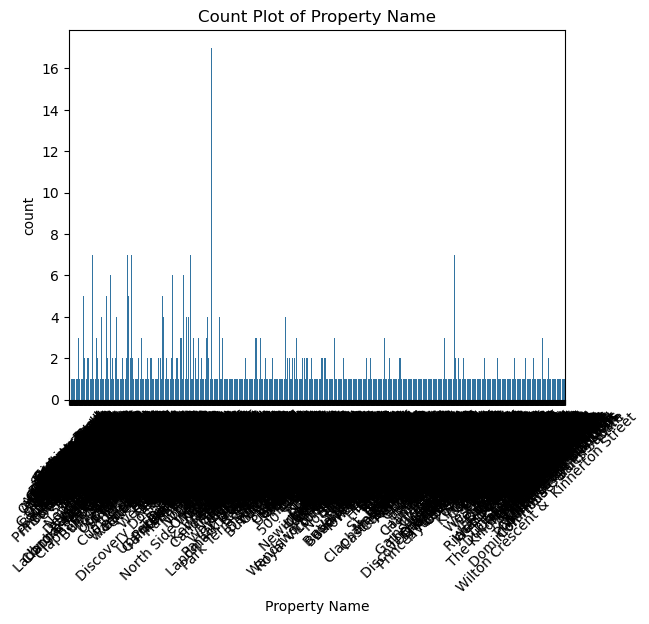

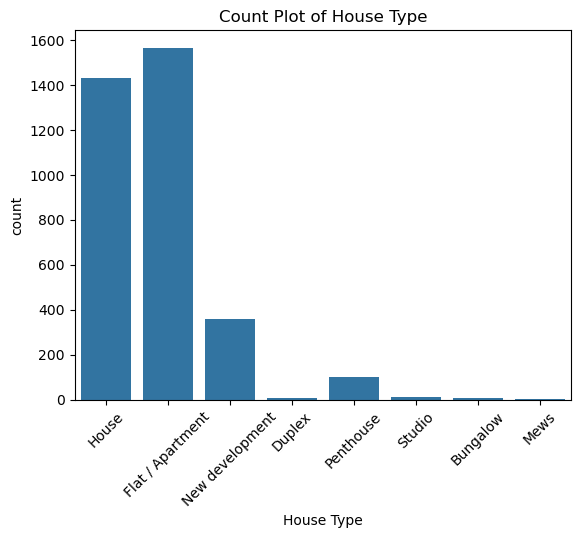

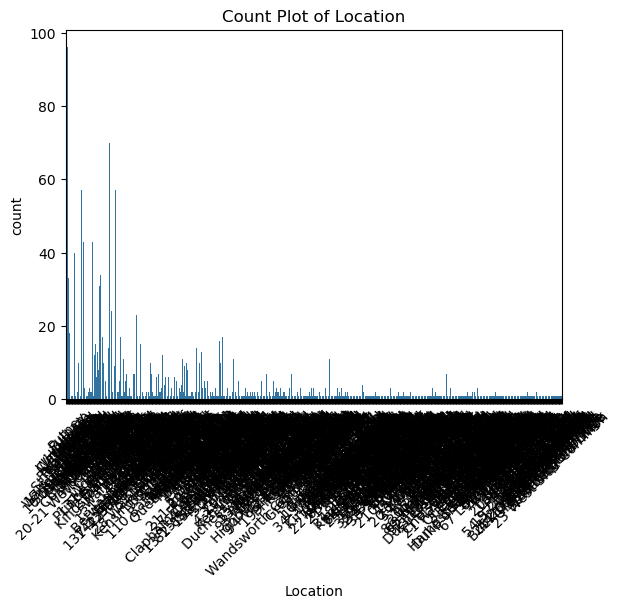

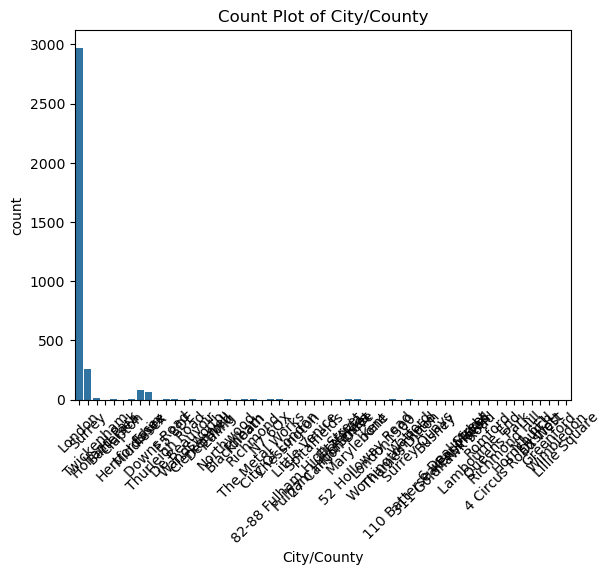

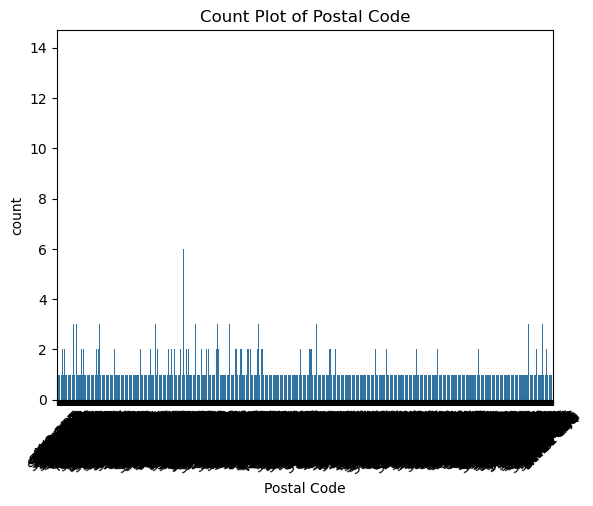

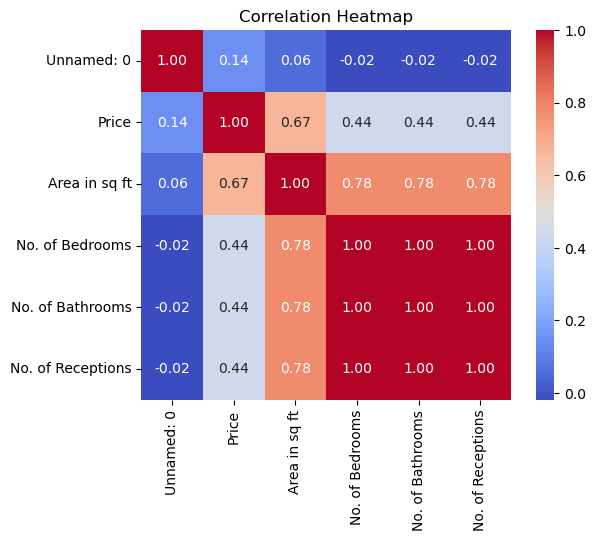